# Shallow feature extraction using `Harpy`.


Using Harpy, we can compute shallow features for all instances in a labels layer based on their corresponding regions in the image layer. These features include total intensity, mean intensity, variance, skewness, and more. To do this, we rely on the Harpy function `harpy.tb.allocate_intensity` (which uses the more general `harpy.utils.RasterAggregator`).

In this notebook, we demonstrate how to extract shallow features from spatial transcriptomics data. The same workflow also applies to spatial proteomics data, see the corresponding [notebook](../general/Harpy_feature_calculation.ipynb).


In [33]:
import harpy as hp

## Example 1: [Molecular Cartography](https://resolvebiosciences.com/) data.

In [34]:
from harpy.datasets import resolve_example

sdata = resolve_example()

/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_26_11_25/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3699: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new location using `sdata.write()`.
  exec(code_obj, self.user_global_ns, self.user_ns)
no parent found for <ome_zarr.reader.Label object at 0x7ef7a7e01550>: None
no parent found for <ome_zarr.reader.Label object at 0x7ef7a61d7200>: None


Visualize the segmentation mask.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


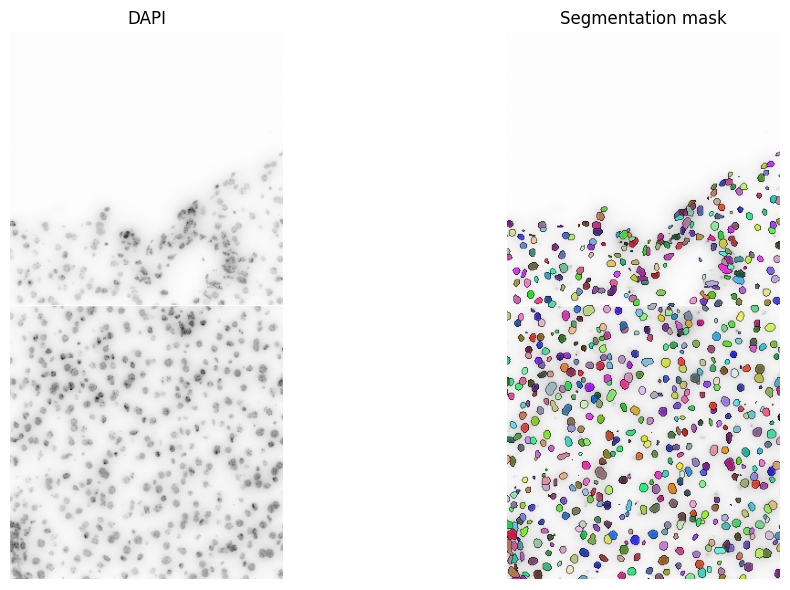

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # figsize=(10, 5))

channel = "DAPI"
# normalization parameters for visualization (underlying image not changed)

render_images_kwargs = {"cmap": "binary"}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}
show_kwargs = {
    "title": "DAPI",
    "colorbar": False,
}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer="raw_image",
    channel=0,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
_ax.axis("off")

show_kwargs = {
    "title": "Segmentation mask",
    "colorbar": False,
}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer="raw_image",
    labels_layer="segmentation_mask",
    channel=0,
    render_images_kwargs=render_images_kwargs,
    render_labels_kwargs=render_labels_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
_ax.axis("off")

plt.tight_layout()
plt.show()

Rechunk, so the labels layer and image layer have same spatial (('z'), 'y', 'x') chunk size.

In [36]:
# first make sure image layer and labels layer have the same chunk size
chunk_size = 1024
img_layer = "raw_image"
labels_layer = "segmentation_mask"

# rechunk
sdata = hp.im.add_image_layer(
    sdata,
    arr=hp.im.get_dataarray(sdata, layer=img_layer).data.rechunk(chunk_size),
    output_layer=img_layer,
    c_coords=["DAPI"],
    overwrite=True,
)

sdata = hp.im.add_labels_layer(
    sdata,
    arr=hp.im.get_dataarray(sdata, layer=labels_layer).data.rechunk(chunk_size),
    output_layer=labels_layer,
    overwrite=True,
)

2025-12-02 19:51:07,725 - harpy.image._manager - INFO - Writing results to layer 'raw_image'
2025-12-02 19:51:07,788 - harpy.image._manager - INFO - Writing results to layer 'segmentation_mask'


Now, lets aggregate the image and labels layer and calculate the following shallow features: `'sum'`, '`var`', '`skew`', '`count`'*(=instance size)*.

The total intensity (`'sum'`), will be added to the `.X` attribute of the `AnnData` table. The other features will be added to the `.obs` attribute of the table.

In [46]:
sdata = hp.tb.allocate_intensity(
    sdata,
    img_layer="raw_image",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    mode="sum",
    obs_stats=["var", "skew", "count"],  # count will be added as "nucleus_size" in .obs
    instance_size_key="nucleus_size",
    calculate_center_of_mass=True,
    spatial_key="spatial",
)

display(sdata["table_intensities"])
display(sdata["table_intensities"].to_df().head())
display(sdata["table_intensities"].obs.head())
display(sdata["table_intensities"].obsm["spatial"][:5])  # -> center of mask

/data/groups/technologies/spatial.catalyst/Arne/harpy/src/harpy/utils/_aggregate.py:478: RuntimeWarning: invalid value encountered in divide
  skewness = (sum_third / count) / (np.sqrt(sum_square / count)) ** 3
2025-12-02 19:55:03,364 - harpy.utils._aggregate - WARNING - Replacing NaN values in 'skewness' with 0 for affected cells.
/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_26_11_25/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3699: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  exec(code_obj, self.user_global_ns, self.user_ns)
/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_26_11_25/lib/python3.12/site-packages/anndata/_core/anndata.py:829: ImplicitModificationWarning: Transforming to str index.
  self._set_dim_df(value, "obs")


AnnData object with n_obs × n_vars = 657 × 1
    obs: 'cell_ID', 'fov_labels', 'var_DAPI', 'skew_DAPI', 'nucleus_size'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

channels,DAPI
cells,
1_segmentation_mask_e572cecb,1675982.0
2_segmentation_mask_e572cecb,4928528.0
4_segmentation_mask_e572cecb,4872624.0
5_segmentation_mask_e572cecb,2925965.0
7_segmentation_mask_e572cecb,2936661.0


,cell_ID,fov_labels,var_DAPI,skew_DAPI,nucleus_size
cells,,,,,
1_segmentation_mask_e572cecb,1,segmentation_mask,801741.18750,2.417326e+07,1063.0
2_segmentation_mask_e572cecb,2,segmentation_mask,293185.37500,5.015107e+07,2317.0
4_segmentation_mask_e572cecb,4,segmentation_mask,320540.90625,4.637180e+07,2192.0
5_segmentation_mask_e572cecb,5,segmentation_mask,168423.75000,7.530612e-01,1777.0
7_segmentation_mask_e572cecb,7,segmentation_mask,461050.06250,1.617385e-01,1417.0


array([[2125.67638758,  961.25117592],
       [2068.32887354, 1036.62926198],
       [2016.3020073 , 1052.68385036],
       [2033.00844119, 1103.77940349],
       [1748.87579393, 1120.17431193]])

INFO     Rasterizing image for faster rendering.                                                                   


INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


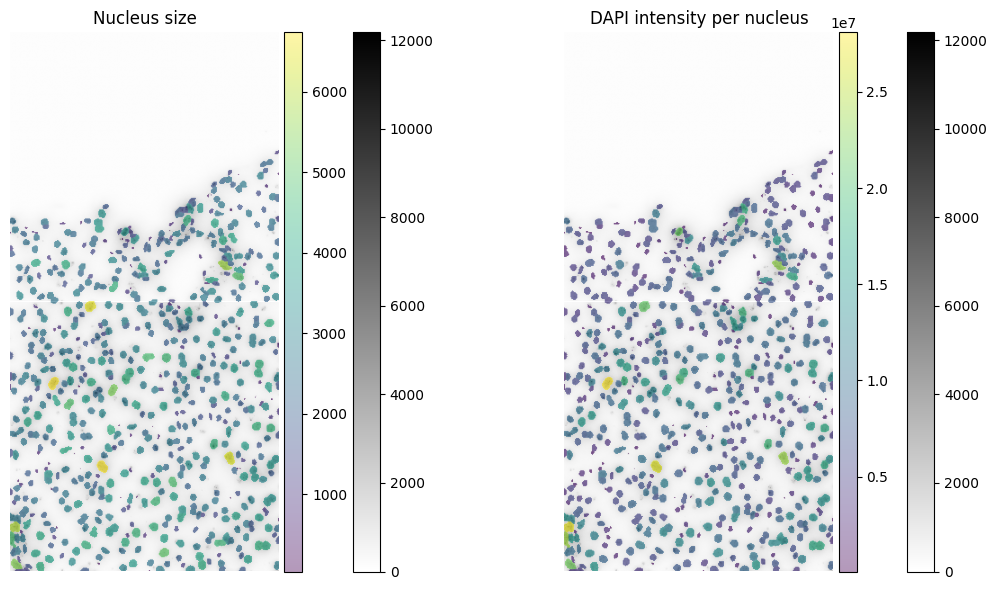

In [47]:
# visualize the info with spatialdata-plot

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# normalization parameters for visualization (underlying image not changed)
se = hp.im.get_dataarray(sdata, layer="raw_image")

channel = "DAPI"

render_images_kwargs = {"cmap": "binary"}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# color by area
color = "nucleus_size"
show_kwargs = {
    "title": "Nucleus size",
    "colorbar": True,
}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer="raw_image",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
ax.axis("off")

# color by mean intensity
color = channel
show_kwargs = {
    "title": f"{color} intensity per nucleus",
    "colorbar": True,
}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer="raw_image",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
ax.axis("off")

plt.tight_layout()
plt.show()

We also can extract geometric and morphological information based on the shape of the cells and append it as extra observations to our table. This can be useful to distinguish between different cell types. For example, we can calculate the area of the cell, the perimeter, the eccentricity, the solidity, the major and minor axis.

In [48]:
sdata = hp.tb.add_regionprop_features(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    output_layer="table_intensities",
    properties=[ "perimeter", "eccentricity"],
    overwrite=True,
)
display(sdata["table_intensities"].obs.head())

/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_26_11_25/lib/python3.12/site-packages/anndata/_core/anndata.py:829: ImplicitModificationWarning: Transforming to str index.
  self._set_dim_df(value, "obs")


,cell_ID,fov_labels,var_DAPI,skew_DAPI,nucleus_size,perimeter,eccentricity
cells,,,,,,,
1_segmentation_mask_e572cecb,1,segmentation_mask,801741.18750,2.417326e+07,1063.0,127.254834,0.756004
2_segmentation_mask_e572cecb,2,segmentation_mask,293185.37500,5.015107e+07,2317.0,180.953319,0.491016
4_segmentation_mask_e572cecb,4,segmentation_mask,320540.90625,4.637180e+07,2192.0,177.781746,0.675326
5_segmentation_mask_e572cecb,5,segmentation_mask,168423.75000,7.530612e-01,1777.0,156.124892,0.569551
7_segmentation_mask_e572cecb,7,segmentation_mask,461050.06250,1.617385e-01,1417.0,157.231493,0.795358


Note that using the `harpy.utils.RasterAggregator` class, we can also calculate the  'quantiles', 'radii' and 'principal_axes'.

In [32]:
import harpy as hp

img_array = sdata[img_layer].data[:, None, ...]
mask_array = sdata[labels_layer].data[None, ...]

aggregator = hp.utils.RasterAggregator(mask_dask_array=mask_array, image_dask_array=img_array)
df_quantiles = aggregator.aggregate_quantiles(depth=200, quantiles=[0.1, 0.3, 0.5, 0.7, 0.9])

display(df_quantiles[0].head())  # -> 0.1 quantile intensity for each cell and each channel
display(df_quantiles[-1].head())  # -> 0.9 quantile
df_radii_axes = aggregator.aggregate_radii_and_axes(depth=200, calculate_axes=False)  # raddi
display(df_radii_axes.head())

,0,cell_ID
0,0.000000,1
1,1238.000000,2
2,1370.500000,4
3,1163.199951,5
4,1191.000000,7


,0,cell_ID
0,2644.000000,1
1,2727.000000,2
2,2804.899902,4
3,2179.000000,5
4,3047.000000,7


,0,1,2,cell_ID
0,11.452508,7.496437,0.0,1
1,14.585308,12.705996,0.0,2
2,15.416794,11.370177,0.0,4
3,13.131853,10.793805,0.0,5
4,13.820557,8.377190,0.0,7


## Example 2: [Merscope data](https://info.vizgen.com/mouse-liver-data).

In [10]:
sdata = hp.datasets.merscope_mouse_liver_segmentation_mask()

/data/groups/technologies/spatial.catalyst/Arne/harpy/src/harpy/datasets/transcriptomics.py:334: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new location using `sdata.write()`.
  sdata = read_zarr(os.path.commonpath(unzip_path))
no parent found for <ome_zarr.reader.Label object at 0x7fa8ac6531d0>: None


Back the data to a Zarr store for optimal processing.

In [14]:
import os

from spatialdata import read_zarr

path = os.environ.get( "TMPDIR" ) # This path can be changed to any output folder.

sdata.write( os.path.join( path, "sdata_merscope.zarr" ), overwrite=True )
sdata = read_zarr(sdata.path)

no parent found for <ome_zarr.reader.Label object at 0x7fa88c12db50>: None


First make sure the image and labels layer have the same chunk size on disk, for optimal processing.

In [ ]:
# first make sure image layer and labels layer have the same chunk size

chunk_size = 4096  # pick a chunksize that is not too small
img_layer = "clahe"
labels_layer = "segmentation_mask_full"

# rechunk on disk
sdata = hp.im.add_image_layer(
    sdata,
    arr=hp.im.get_dataarray(sdata, layer=img_layer).data.rechunk(chunk_size),
    output_layer=img_layer,
    c_coords=["DAPI", "PolyT"],
    scale_factors=[2, 2, 2, 2],
    overwrite=True,
)

sdata = hp.im.add_labels_layer(
    sdata,
    arr=hp.im.get_dataarray(sdata, layer=labels_layer).data.rechunk(chunk_size),
    output_layer=labels_layer,
    scale_factors=[2, 2, 2, 2],
    overwrite=True,
)

2025-12-02 15:54:26,353 - harpy.image._manager - INFO - Writing results to layer 'clahe'
2025-12-02 15:56:38,312 - harpy.utils._io - WARNING - layer with name 'clahe' already exists. Overwriting...
2025-12-02 16:02:28,639 - harpy.image._manager - INFO - Writing results to layer 'segmentation_mask_full'
no parent found for <ome_zarr.reader.Label object at 0x7fa8ac7ebad0>: None
2025-12-02 16:03:37,548 - harpy.utils._io - WARNING - layer with name 'segmentation_mask_full' already exists. Overwriting...


Now calculate the total intensity for every cell, and for every channel using `harpy.tb.allocate_intensity`.

In [ ]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    n_workers=8,  # using workers instead of threads is slightly faster on large datasets.
    threads_per_worker=1,
    memory_limit="500GB",  # prevent spilling to disk
    local_directory=os.environ.get("SCRATCHDIR"),
)

client = Client(cluster)
print(client.dashboard_link)

sdata = hp.tb.allocate_intensity(
    sdata,
    img_layer=img_layer,
    labels_layer=labels_layer,
    output_layer="table_intensities",
    mode="sum",
    calculate_center_of_mass=False,
    overwrite=True,
) # takes around 2 minutes

client.close()

In [15]:
display( sdata[ "table_intensities" ].to_df().head() )

channels,DAPI,PolyT
cells,,
1025_segmentation_mask_full_20d49a42,12554694.0,50630048.0
1026_segmentation_mask_full_20d49a42,114171.0,406149.0
1027_segmentation_mask_full_20d49a42,1000944.0,7133834.0
1028_segmentation_mask_full_20d49a42,10002447.0,26179680.0
1031_segmentation_mask_full_20d49a42,10884798.0,35758056.0


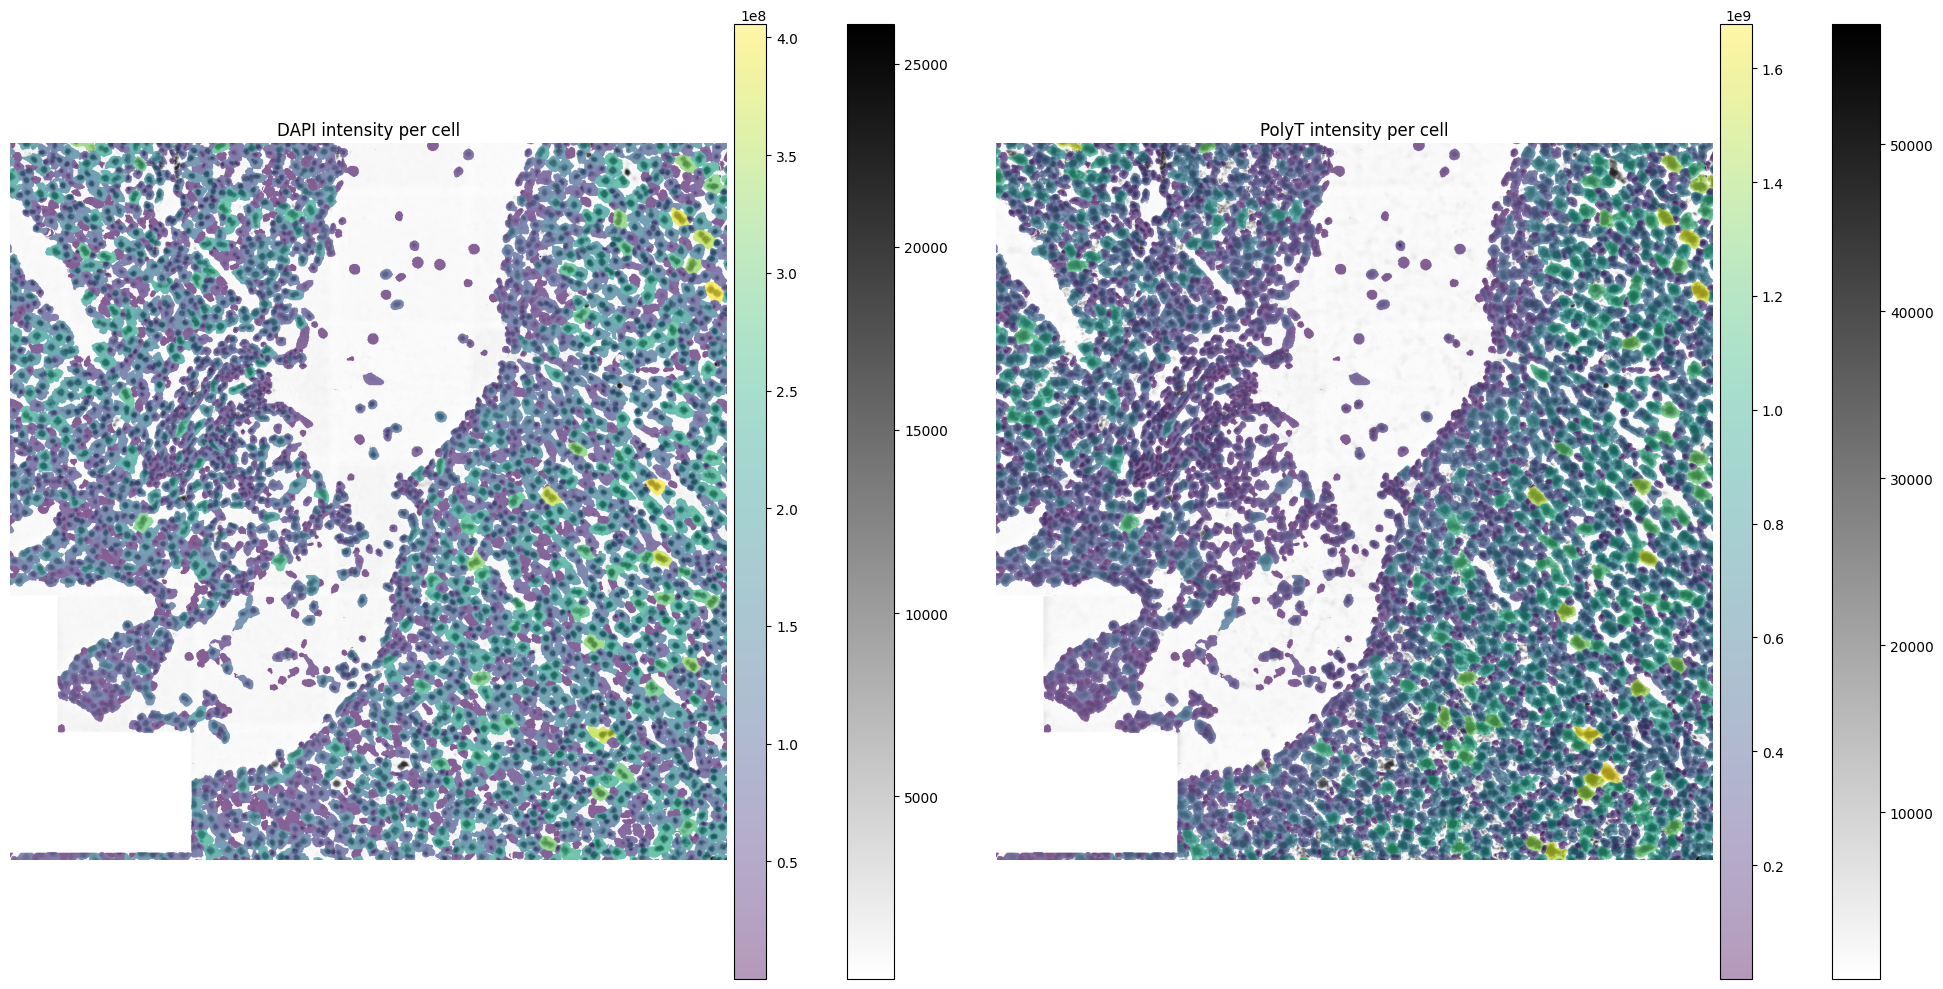

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

se = hp.im.get_dataarray(sdata, layer="clahe")

channels = se.c.data

render_images_kwargs = {"cmap": "binary"}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# subset, because query is slow on points layer
sdata_to_plot=sdata.subset( element_names=[img_layer, labels_layer] )

for channel, ax in zip(channels, axes, strict=True):

    color = channel
    show_kwargs = {
        "title": f"{color} intensity per cell",
        "colorbar": True,
    }
    ax = hp.pl.plot_sdata(
        sdata_to_plot,
        img_layer=img_layer,
        channel=channel,
        labels_layer=labels_layer,
        table_layer="table_intensities",
        crd = [ 20000, 30000, 20000, 30000 ],
        color=color,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        to_coordinate_system="global",
        ax=ax,
    )
    ax.axis("off")

plt.tight_layout()
plt.show()